# <center>The Most Popular Data Science Questions</center>
## Table of Contents

* [1. Introduction](#introduction)
* [2. Ask](#ask)
    * [2.1 The business task](#business_task)
    * [2.2 Key stakeholders](#key_stakeholder)
* [3. Prepare](#prepare)
    * [3.1 Data source](#data_source)
        * [3.1.1 Accessibility and privacy](#data_privacy)
        * [3.1.2 Data organization](#data_organization) 
    * [3.2 Exploring the data](#exploring)
* [4. Process](#process)
* [5. Analyze and Share](#analyze)
    * [Question 1: What questions are most popular?](#q1)
    * [Question 2: Are these questions rising or falling in popularity?](#q2)
    * [Question 3: When are these questions asked the most?](#q3)
    * [Question 4: Is R potentially popular?](#q4)
* [6. Act & Recommendations](#act)


<a id="introduction"></a>
## 1. Introduction

In recent years, more and more people are learning professional knowledge through the Internet. [A report in 2017](https://www.techrepublic.com/article/report-59-of-employed-data-scientists-learned-skills-on-their-own-or-via-a-mooc/) indicates that up to 32% of full-time data scientists learned data science through online courses. Due to pandemic, the number should still be rising.

In this project, there is a newly established fictional company called **Datamagician** that provides online education about Data Science. To attract more users, they want to create contents based on what people are most interested in Data Science. They hire us as data analysts and want some advice from us.

They don't have any historical data for analyzing yet, so first and foremost, we need to find a reliable data source. After some investigation, we think **Stack Exchange** is good choice. It's a network of question-and-answer websites, one of its most famous website is Stack Overflow. It employs a reputation award system for its questions and answers. Each post is consists of one question and multiple answers, and question/answer is subject to upvotes and downvotes. This ensures that good posts are easily identifiable. Moreover, it provides a link to query and explore its database.

Given that, we are going to investigate its data sciense site **[Data Science Stack Exchange](https://datascience.stackexchange.com)** to determine what questions/topics are most popular, based on interest by subject. The database can be queried by [this link](https://data.stackexchange.com/datascience/query/new).   

<a name="ask"></a>
## 2. Ask

<a id="business_task"></a>
### 2.1 The Business Task

As data analysts, we need to analyze the data and find out the most popular data science questions, and provide recommendations about what content Datamagician should create. Our report should be backed up with compelling data insights and professional data visualizations.

<a id="key_stakeholder"></a>
### 2.2 Key Stakeholders

- **The analytics team we are working for**: A team of data analysts who are responsible for collecting, analyzing, and reporting data that helps guide Datamagician marketing strategy.
- **Datamagician executive team**: The executive team of our client, Datamagician. They are detail-oriented and will decide whether to approve our recommendations.


<a id="prepare"></a>
## 3. Prepare

<a id="data_source"></a>
### 3.1 Data source

We can run SQL queries to download the dataset from [Data Science Stack Exchange Query](https://data.stackexchange.com/datascience/query/new).

<a id="data_privacy"></a>
#### 3.1.1 Accessibility and privacy
The license can be found [here](https://stackoverflow.com/help/licensing), we can use it to explore the most popular data science questions.

<a id="data_organization"></a>
#### 3.1.2 Data organization

By checking the table names in the dataset link above , the following seems related to our goal:

|Database Schema|
|----|
|Comments|
|Posts|
|PostTags|
|Tags|

Let's double check by selecting a few rows of each table.

**Comments**
```
SELECT TOP 1 * FROM Comments
```

The first row:

|Id||PostId||Score||Text||CreationDate||UserDisplayName||UserId||ContentLicense|
|--||--||--||---||----||----||----||----|
|5||5||9||this is a super theoretical AI question. An interesting discussion! but out of place...||2014-05-14 00:23:15||||34||CC BY-SA 3.0|

**Posts**
```
SELECT TOP 1 * FROM Posts
```
The first row:

|Id||PostTypeId||AcceptedAnswerId||ParentId||CreationDate||DeletionDate||Score||ViewCount||Body||OwnerUserId||OwnerDisplayName||LastEditorUserId||LastEditorDisplayName||LastEditDate||LastActivityDate||Title||Tags||AnswerCount||CommentCount||FavoriteCount||ClosedDate||CommunityOwnedDate||ContentLicense|
|--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--||--|
|56889||1||||||2019-08-03 12:05:21||||2||185||<p>I'm trying to build a Deep Learning predictor that takes as the input a set of word vectors...</p>||25163||||25163||||2019-08-04 16:06:06||2022-02-27 02:01:30||Hyperbolic coordinates (Poincaré embeddings) as the output of a neural network||\<deep-learning\>\<keras\>\<manifold\>||1||1||||||||CC BY-SA 4.0|

**PostTags**
```
SELECT TOP 1 * FROM PostTags
```
The first row:
    
|PostId||TagId|
|---||---|
|14||1|
    
**Tags**
```
SELECT TOP 1 * FROM Tags
```
The first row:
    
|Id||TagName||Count||ExcerptPostId||WikiPostId||IsModeratorOnly||IsRequired|
|---||---||---||---||---||---||---|
|1||definitions||37||105||104|||||||
    
   

After comparing those tables, `Posts` table is our best option, we can group them by column `Tags`. While the other tables are not that good because:
   
* `Comments` doesn't have any tags so we cannot group them.
* The data of `PostTags` are inplicit in `Posts`.
* `Tags` doesn't have any date info, we cannot find its trend over time.
  And its info is included in table `Posts`
    
As for `Posts` table, its column `PostTypeId` is the `Id` of `PostTypes` table, which is:
    
|Id||Name|
|---||----|
|1||Question|
|2||Answer|
|3||Wiki|
|4||TagWikiExcerpt|
|5||TagWiki|
|6||ModeratorNomination|
|7||WikiPlaceholder|
|8||PrivilegeWiki|
    
Since we are investigating questions, we should only select posts with `PostTypeId` = 1. And we will focus on recent questions, by limiting the `CreationDate` from 2021 to current. Here is the query:
```
SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND YEAR(CreationDate) >= 2021;
```
It returns 8137 rows, which should be enough for analyzing. Let's download and save it as CSV file `stackexchange_ds_qs_2021_202205.csv`.

<a id="exploring"></a>
### 3.2 Exploring the data

#### Read the data

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

# read the csv
questions = pd.read_csv("stackexchange_ds_qs_2021_202205.csv")

# check the first 5 rows
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,87391,2021-01-01 03:10:42,1,34,<decision-trees>,1,NaN
1,87392,2021-01-01 07:28:07,0,34,<machine-learning><python><deep-learning><imag...,1,NaN
2,87393,2021-01-01 08:07:33,1,21,<neural-network><deep-learning><inception>,0,NaN
3,87395,2021-01-01 10:31:51,1,45,<machine-learning><cloud><federated-learning>,1,1.0
4,87404,2021-01-01 18:00:21,1,59,<reinforcement-learning><openai-gym>,1,NaN


#### Data size

In [2]:
questions.shape

(8137, 7)

#### Find duplicates

In [3]:
questions[questions.duplicated(['Id'], keep=False)]

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount


The dataset has no duplicates.

#### Check missing values

In [4]:
# Run `info()` to get each column's data type and count of NAs.
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8137 non-null   int64  
 1   CreationDate   8137 non-null   object 
 2   Score          8137 non-null   int64  
 3   ViewCount      8137 non-null   int64  
 4   Tags           8137 non-null   object 
 5   AnswerCount    8137 non-null   int64  
 6   FavoriteCount  650 non-null    float64
dtypes: float64(1), int64(4), object(2)
memory usage: 445.1+ KB


All the missing values are in `FavoriteCount` column, what is it? In the first 5 rows, we can see the post with id `87395` has `FavoriteCount = 1` while id `87404` has `FavoriteCount = NaN`. After checking the corresponding post pages [Post 87395](https://datascience.stackexchange.com/questions/87395/dividing-a-dataset-to-parallelize-machine-learning-training-on-the-cloud) and [Post 87404](https://datascience.stackexchange.com/questions/87404/effects-of-slipperiness-in-openai-frozenlake-environment), we can find out FavoriteCount shows how many users have bookmarked that post, while NaN means that post has not bookmarked by any user.

Therefore, we can replace the missing values with `0`. And we can change its data type to int, since count will not be float.

Next, let's see what types the objects in `Tags` are.

In [5]:
questions["Tags"].apply(lambda v: type(v)).unique()

array([<class 'str'>], dtype=object)

Now we know that every value in this column is a string. Later we will need to change its format to make it more readable.

<a id="process"></a>
## 4. Process

As we've mentioned above, we need to fill up `FavoriteCount` and make `Tags` more readable.

In [6]:
# fill missing values with 0
questions.fillna(0, inplace = True)

# convert `FavoriteCount` to int
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)

# convert Tags to lowercase
questions["Tags"] = questions["Tags"].str.lower()

# make `Tags` more readable
questions["Tags"] = questions["Tags"].str[1:-1].str.split("><")

# verify the first 5 rows
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,87391,2021-01-01 03:10:42,1,34,[decision-trees],1,0
1,87392,2021-01-01 07:28:07,0,34,"[machine-learning, python, deep-learning, imag...",1,0
2,87393,2021-01-01 08:07:33,1,21,"[neural-network, deep-learning, inception]",0,0
3,87395,2021-01-01 10:31:51,1,45,"[machine-learning, cloud, federated-learning]",1,1
4,87404,2021-01-01 18:00:21,1,59,"[reinforcement-learning, openai-gym]",1,0


<a id="analyze"></a>
## 5. Analyze and Share

Let's do a basic data analysis by answering below questions:
<a id="q1"></a>
### Question 1: What questions are most popular?

Our goal is to find the most popular questions (posts whose post type is questions), since posts are categoried by tags, we are actually looking for the most popular tags.

However, "popular" is a ambiguous word, we will break it into 3 sub questions.

#### Question a) Which tags are most used?

In [7]:
tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

For convenience, we can convert it to a data frame:

In [8]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index", columns=["Count"])

# sort it by tags frequency ascending
tag_count.sort_values(by=['Count'], ascending=False, inplace=True)
tag_count

,Count
machine-learning,2200
python,1457
deep-learning,1180
neural-network,747
nlp,703
...,...
lsi,1
ngboost,1
snorkel,1
labeling,1


There are 623 tags, and many of them have 1 occurrences only. Let's focus on the top 30 (around 0.5% of 623) tags: 

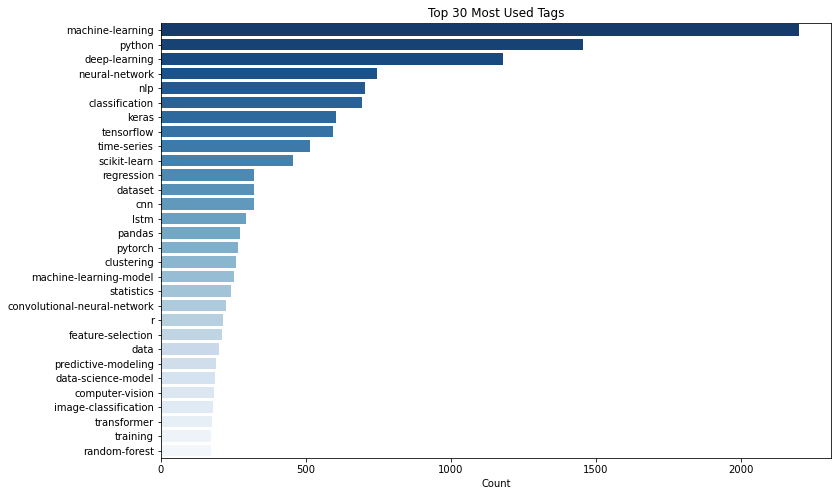

In [9]:
most_used = tag_count.head(30)
plt.figure(figsize=(12, 8))
sns.barplot(x='Count',
            y=most_used.index,
            data=most_used,
            palette="Blues_r").set(title='Top 30 Most Used Tags')
plt.show()

#### Question b) Which Tags are Most Viewed?

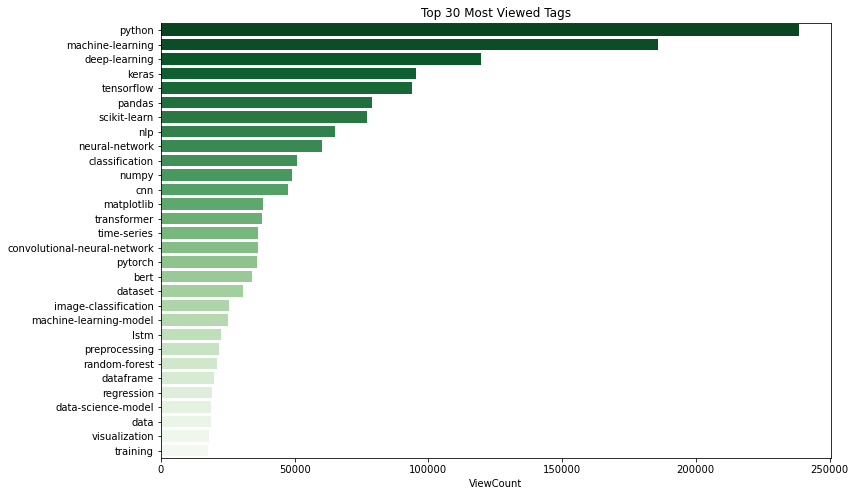

In [10]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index", columns=["ViewCount"])

# sort it by tags frequency ascending
tag_view_count.sort_values(by=['ViewCount'], ascending=False, inplace=True)

# plot the top 30 most viewed
most_viewed = tag_view_count.head(30)
plt.figure(figsize=(12, 8))
sns.barplot(x='ViewCount',
            y=most_viewed.index,
            data=most_viewed,
            palette="Greens_r").set(title='Top 30 Most Viewed Tags')
plt.show()

#### Question c) Which Tags are Most Favorited?

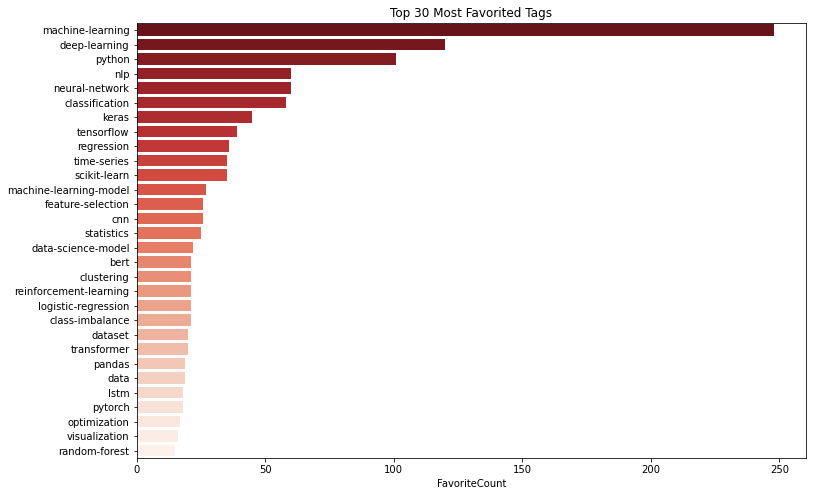

In [11]:
tag_fav_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_fav_count:
            tag_fav_count[tag] += row['FavoriteCount']
        else:
            tag_fav_count[tag] = row['FavoriteCount']
            
tag_fav_count = pd.DataFrame.from_dict(tag_fav_count, orient="index", columns=["FavoriteCount"])

# sort it by tags frequency ascending
tag_fav_count.sort_values(by=['FavoriteCount'], ascending=False, inplace=True)

# plot the top 30
most_favorited = tag_fav_count.head(30)
plt.figure(figsize=(12, 8))
sns.barplot(x='FavoriteCount',
            y=most_favorited.index,
            data=most_favorited,
            palette="Reds_r").set(title='Top 30 Most Favorited Tags')
plt.show()

We've answered the 3 sub-questions by plots, let's put them in one row for comparision:

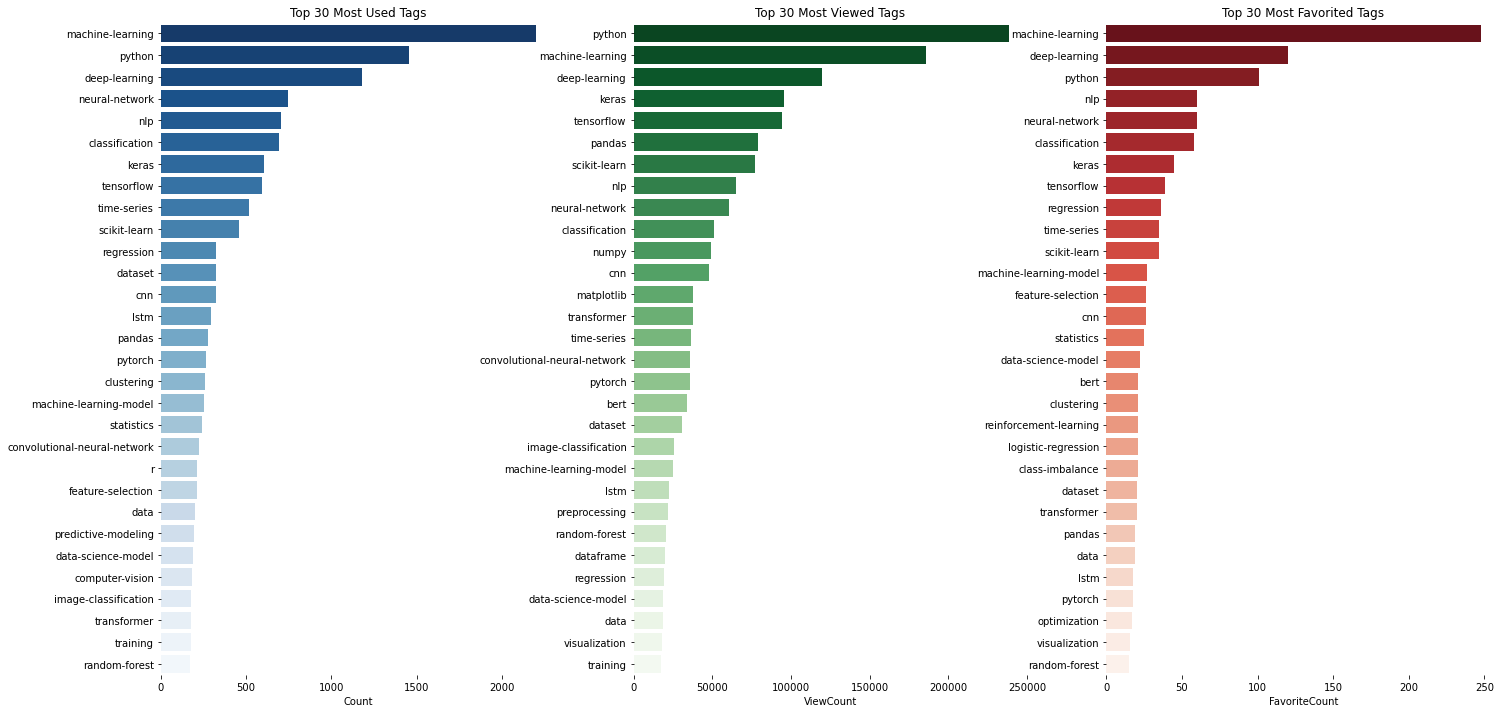

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,12))
sns.despine(bottom = True, left = True)
sns.barplot(x='Count',
            y=most_used.index,
            data=most_used,
            ax=axes[0],
            palette="Blues_r").set(title='Top 30 Most Used Tags')
sns.barplot(x='ViewCount',
            y=most_viewed.index,
            data=most_viewed,
            ax=axes[1],
            palette="Greens_r").set(title='Top 30 Most Viewed Tags')
sns.barplot(x='FavoriteCount',
            y=most_favorited.index,
            data=most_favorited,
            ax=axes[2],
            palette="Reds_r").set(title='Top 30 Most Favorited Tags')

plt.show()

As we can see from above plot, most tags rank differently in different plots, but we can still find some patterns. For example, `machine-learning`, `python` and `deep-learning` are always the top 3 tags in whichever list.

Next, let's find all tags shared by 3 plots:

In [13]:
# get tags show up in all 3 plots
used_viewed_tags = pd.merge(most_used, most_viewed, how="inner", left_index=True, right_index=True)
top_tags = pd.merge(used_viewed_tags, most_favorited, how="inner", left_index=True, right_index=True)
top_tags.sort_values(by=['Count'], ascending=False, inplace=True)
top_tags

,Count,ViewCount,FavoriteCount
machine-learning,2200,185735,248
python,1457,238437,101
deep-learning,1180,119743,120
neural-network,747,60335,60
nlp,703,65026,60
classification,693,50830,58
keras,603,95310,45
tensorflow,594,94016,39
time-series,515,36275,35
scikit-learn,456,76995,35


It returns 21 tags that are most used, viewed and favorited by people using Data Science Stack Exchange. We may notice some tags are not classified in a perfect way:

* Some tags have overlap. For example, `machine-learning-model` is a subset of `machine-learning`. 
* Some tags are too general, like `python`.


Given that, we can conclude the most popular questions are related to Machine Learning, because `python` is the most popular programming for machine learning. `deep-learning` is a subfield of machine learning, `neural-network` make up the backbone of deep learning algorithms.

If machine learning is still too broad, to be more specific, we can suggest Datamagician create content focus on **Deep Learning**, using Python. And also suggest them provide practical tutorials for tools like `tensorflow` and `scikit-learn`.

<a id="q2"></a>
### Question 2: Are these questions rising or falling in popularity?

We've known the most popular questions from 2021 to current are about `deep-learning`. We focus on recent data because information in Internet is changing rapidly, questions years ago might not that helpful to us.

However, we do care about the trend. Is the popularity rising or falling? What if it's actually falling quickly when it's still high for now? To answer such questions, we need to get all the historical data.

#### Getting All the Historical Data

Run the query below to get the whole questions dataset.

```
SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1;
```

Download and save the file as `stackexchange_ds_qs_all.csv`. Next, we will repeat the process as we did for questions of 2021-2022, and one extra step, we need to parse the column `CreationDate` to datetime since we need to find tags' popularity over time.

In [14]:
# read the csv
all_questions = pd.read_csv("stackexchange_ds_qs_all.csv", parse_dates=["CreationDate"])

# fill missing values 0 and make `FavoriteCount` int
all_questions.fillna(0, inplace = True)
all_questions["FavoriteCount"] = all_questions["FavoriteCount"].astype(int)

# make `Tags` more readable
all_questions["Tags"] = all_questions["Tags"].str[1:-1].str.split("><")

# take a look at the first 5 rows
all_questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,5,2014-05-13 23:58:30,9,834,[machine-learning],1,1
1,7,2014-05-14 00:11:06,4,463,"[education, open-source]",3,1
2,14,2014-05-14 01:25:59,25,1878,"[data-mining, definitions]",4,6
3,15,2014-05-14 01:41:23,2,650,[databases],0,0
4,16,2014-05-14 01:57:56,17,424,"[machine-learning, bigdata, libsvm]",2,0


The data is as early as 2014, that's 8 years ago. The time span is 96 months, around 3000 days, apparently neither month nor day is a good choice for x axis. Instead, we can use quarts(every 3 months). And we can also group them by month and day of week, and see if people asked more questions on specific months or days.

#### Converting CreationDate to Quarter, Month and Day of Week

In [15]:
# Remove the data of current quarter 2022 Q2 because it's incomplete
to_date = datetime.strptime("03/31/2022", '%m/%d/%Y')
all_questions = all_questions[all_questions["CreationDate"] <= to_date]
all_questions["Month"] =  all_questions["CreationDate"].dt.month
all_questions["DOW"] = all_questions["CreationDate"].dt.strftime("%A")

Then create a function to convert datetime to quarter.

In [16]:
def get_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return f"{year}Q{quarter}"

all_questions["Quarter"] = all_questions["CreationDate"].apply(get_quarter)
all_questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,Month,DOW,Quarter
1016,28922,2018-03-10 17:14:12,0,62,"[machine-learning, data-cleaning, preprocessing]",2,0,3,Saturday,18Q1
28144,25253,2017-11-30 14:08:58,1,257,"[machine-learning, classification, text]",1,0,11,Thursday,17Q4
4764,87033,2020-12-22 20:06:15,1,60,"[machine-learning, python, nlp, recommender-sy...",1,0,12,Tuesday,20Q4


#### Distinguishing Tag `deep-learning` from Others

Then we need to list all unqiue tags and then find out which belongs to `deep-learning`.

In [17]:
tag_list = []

for tags in all_questions["Tags"]:
    for tag in tags:
        if tag not in tag_list:
            tag_list.append(tag)
print(sorted(tag_list))           

['.net', '3d-object-detection', '3d-reconstruction', 'ab-test', 'accuracy', 'activation-function', 'active-learning', 'activity-recognition', 'actor-critic', 'adaboost', 'adversarial-ml', 'agglomerative', 'aggregation', 'ai', 'alex-net', 'algorithms', 'allennlp', 'amazon-ml', 'anaconda', 'ann', 'annotation', 'anomaly', 'anomaly-detection', 'anonymization', 'anova', 'apache-hadoop', 'apache-kafka', 'apache-mahout', 'apache-pig', 'apache-spark', 'api', 'arima', 'association-rules', 'attention-mechanism', 'auc', 'audio-recognition', 'autoencoder', 'automatic-summarization', 'automation', 'automl', 'aws', 'aws-lambda', 'azure-ml', 'backpropagation', 'bag-of-words', 'bagging', 'bahdanau', 'bar-chart', 'bart', 'batch-normalization', 'bayes-error', 'bayesian', 'bayesian-networks', 'bayesian-nonparametric', 'beginner', 'bernoulli', 'bert', 'best-practice', 'bias', 'bigdata', 'binary', 'binary-classification', 'bioinformatics', 'bokeh', 'books', 'boosting', 'bootstraping', 'boruta', 'c', 'c++',

Here is the list of tags belong to `deep-learning`:

* `cnn`: Convolutional Neural Networks
* `lstm`: Long Short Term Memory Networks
* `rnn`: Recurrent Neural Networks
* `gan`: Generative Adversarial Networks 
* `mlp`: Multilayer Perceptrons
* `rbm`: Restricted Boltzmann Machines
* `autoencoder`: a type of neural network
* `scikit-learn`: a machine learning(and deep-learning) library for the Python programming language
* `tensorflow`: an open-source library developed by Google primarily for deep learning applications
* `keras`: a deep learning API written in Python
* `neural-network`: a subset of machine learning and are at the heart of deep learning algorithms
* `deep-learning`

Next, let's create a function that assigns 1 to deep learning questions and 0 otherwise.

In [18]:
deep_learning_tags = [
    'cnn',
    'lstm',
    'rnn',
    'gan',
    'mlp',
    'rbm',
    'autoencoder',
    'scikit-learn',
    'tensorflow',
    'keras',
    'neural-network',
    'deep-learning',
    ]
def belongs_deep_learning(tags):
    for tag in tags:
        if tag in deep_learning_tags:
            return 1
    return 0

# Add a new column `DeepLearning`
all_questions["DeepLearning"] = all_questions["Tags"].apply(belongs_deep_learning)

all_questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount,Month,DOW,Quarter,DeepLearning
2690,85331,2020-11-13 03:40:38,1,15,"[machine-learning, data, data-science-model, m...",0,0,11,Friday,20Q4,0
28816,79799,2020-08-05 06:09:15,0,87,"[python, deep-learning, scikit-learn, statisti...",0,0,8,Wednesday,20Q3,1
15271,14834,2016-10-30 19:28:26,0,506,"[algorithms, optimization]",1,1,10,Sunday,16Q4,0


#### Tracking Its Popularity Quarterly

Let's create a summarized dataframe grouped by quarter.

In [19]:
q_grouped = all_questions.groupby('Quarter')
dl_grouped = q_grouped["DeepLearning"]
dl_df = dl_grouped.agg(["size", "sum"])
dl_df.columns = ["TotalQuestions", "DLQuestions"]
dl_df["NonDLQuestions"] = dl_df["TotalQuestions"] - dl_df["DLQuestions"]
dl_df["DLQuestionPercentage"] = round(dl_df["DLQuestions"] / dl_df["TotalQuestions"] * 100, 2)
dl_df.reset_index(inplace=True)
dl_df.tail()

,Quarter,TotalQuestions,DLQuestions,NonDLQuestions,DLQuestionPercentage
27,21Q1,1289,486,803,37.70
28,21Q2,1677,646,1031,38.52
29,21Q3,1593,597,996,37.48
30,21Q4,1473,474,999,32.18
31,22Q1,1448,517,931,35.70


Visualize it by stacked bar chart and line chart.

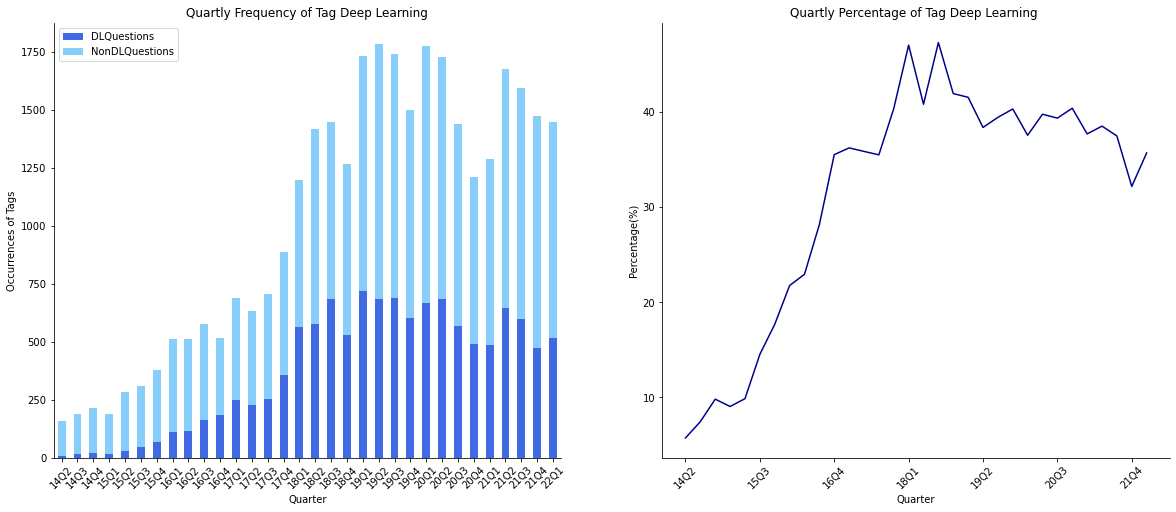

In [20]:
# plot bars in stack manner
fig, axes = plt.subplots(nrows=1, ncols=2)
for i in range(0,2):
    for pos in ['right', 'top']: 
        axes[i].spines[pos].set_visible(False)
fig.set_size_inches((20, 8))

dl_df[['Quarter', 'DLQuestions', 'NonDLQuestions']].plot(
    x='Quarter',
    kind='bar',
    stacked=True,
    ax=axes[0],
    rot=45,
    color=['royalblue', 'lightskyblue'],
    title='Quartly Frequency of Tag Deep Learning',
    )
axes[0].set_ylabel('Occurrences of Tags')

ax2 = dl_df.plot(
    x='Quarter',
    y='DLQuestionPercentage',
    ax=axes[1],
    rot=45,
    kind='line',
    color='darkblue',
    title='Quartly Percentage of Tag Deep Learning ',
    )
axes[1].set_ylabel('Percentage(%)')
axes[1].get_legend().remove()


As we can see from above plots, the percentage of deep learning questions increased rapidly since the start of Data Science Stack Exchange, and begins to flatten out in recent 2 years. It dropped a little in 2021 Q4 but it's back up in next quarter and still keep high proportion at around 40%.

We insist our previous conclusion, i.e., we suggest the company Datamagician create content focus on **Deep Learning**.

<a id="q3"></a>
### Question 3: When are these questions asked the most?

What if Datamagician wants to offer promotions about their online deep learning courses, is there any month or day of week that attracts more people? We can use the popularity as the proxy, because the more people ask questions, the more interested they are, the more likely they are to choose related courses. We can answer that question by tracking the popularity by month and day of week.

#### Tracking its popularity by month

Let's create a summarized dataframe grouped by month.

In [21]:
q_grouped_month = all_questions.groupby('Month')
dl_grouped_month = q_grouped_month["DeepLearning"]
dl_df_month = dl_grouped_month.agg(["size", "sum"])
dl_df_month.columns = ["TotalQuestions", "DLQuestions"]
dl_df_month["DLQuestionPercentage"] = round(dl_df_month["DLQuestions"] / dl_df_month["TotalQuestions"] * 100, 2)
dl_df_month

,TotalQuestions,DLQuestions,DLQuestionPercentage
Month,,,
1,2937,1112,37.86
2,2815,1085,38.54
3,3081,1135,36.84
4,2502,948,37.89
5,2930,1096,37.41
6,2755,932,33.83
7,2846,1077,37.84
8,2751,1052,38.24
9,2402,877,36.51


#### Tracking its popularity by day of week

In [22]:
q_grouped_dow = all_questions.groupby("DOW")
dl_grouped_dow = q_grouped_dow["DeepLearning"]
dl_df_dow = dl_grouped_dow.agg(["size", "sum"])
dl_df_dow.columns = ["TotalQuestions", "DLQuestions"]
dl_df_dow["DLQuestionPercentage"] = round(dl_df_dow["DLQuestions"] / dl_df_dow["TotalQuestions"] * 100, 2)
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dl_df_dow = dl_df_dow.reindex(days)
dl_df_dow

,TotalQuestions,DLQuestions,DLQuestionPercentage
DOW,,,
Monday,5093,1903,37.37
Tuesday,5236,1917,36.61
Wednesday,5387,1974,36.64
Thursday,5271,1936,36.73
Friday,4788,1763,36.82
Saturday,3211,1238,38.55
Sunday,3476,1310,37.69


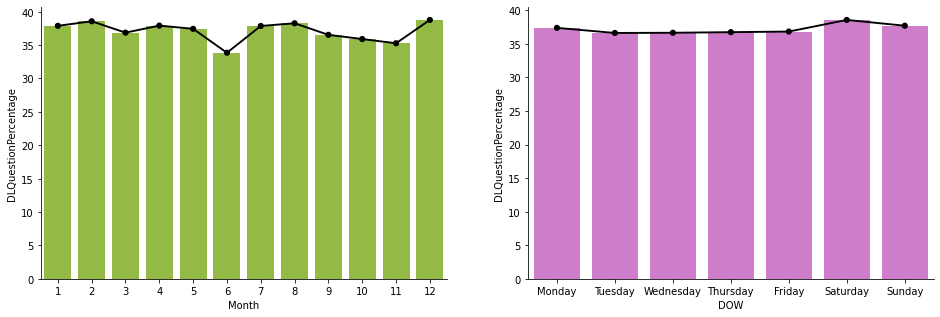

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i in range(0,2):
    for pos in ['right', 'top']: 
        axes[i].spines[pos].set_visible(False)
fig.set_size_inches((16, 5))

# by month
sns.barplot(x=dl_df_month.index, y="DLQuestionPercentage", data=dl_df_month, ax=axes[0], color="yellowgreen")
sns.pointplot(x=dl_df_month.index, y='DLQuestionPercentage', data=dl_df_month, ax=axes[0], color="black", scale=0.7)

# by day of week
sns.barplot(x=dl_df_dow.index, y="DLQuestionPercentage", data=dl_df_dow, ax=axes[1], color="orchid")
sns.pointplot(x=dl_df_dow.index, y='DLQuestionPercentage', data=dl_df_dow, ax=axes[1], color="black", scale=0.7)

plt.show()

#### Heatmap of Popularity

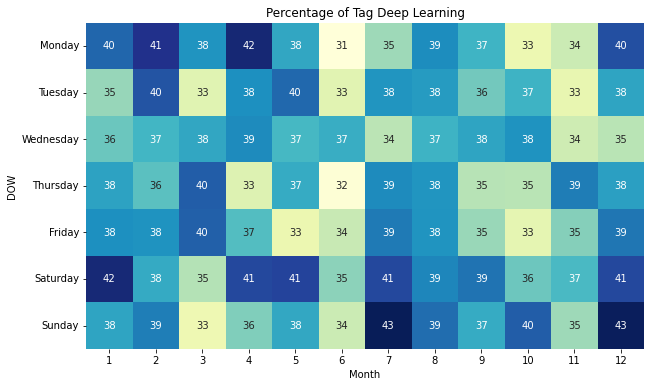

In [24]:
# group by day of week and month
dl_df_hm = all_questions.groupby(["DOW", "Month"])
dl_df_hm = dl_df_hm["DeepLearning"].agg(["size", "sum"])
dl_df_hm.columns = ["TotalQuestions", "DLQuestions"]
dl_df_hm["DLQuestionPercentage"] = round(dl_df_hm["DLQuestions"] / dl_df_hm["TotalQuestions"] * 100, 2)
dl_df_hm = dl_df_hm.reset_index()

# create the pivot table
dl_df_pivot = dl_df_hm.pivot("DOW", "Month", "DLQuestionPercentage")
dl_df_pivot = dl_df_pivot.reindex(index = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

# create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(dl_df_pivot, annot=True, cmap="YlGnBu", cbar=False).set(title="Percentage of Tag Deep Learning")
plt.yticks(rotation=0)
plt.show()

According to above plots, the percentage of deep learning questions are higher in February, August and December. As for day of week, Saturday has the highest percentage of deep learning questions, followed by Sunday. More specifically, the highest share happen on Sunday of July and December.

<a id="q4"></a>
### Question 4: Is R potentially popular?

We've known the most popular programming language in Data Science Stack Exchange is `python`, but we also see `r` in Top 30 Most Used Tags and Most Favorited Tags. Some [articles](https://www.springboard.com/blog/data-science/best-language-for-machine-learning/) claim that R is one of the best languages for machine learning.
Should we also recommend R?

First of all, we need to figure out what tags come together with R. Here is the dataframe shows the relationships between r and other tags.

In [25]:
# all tags in stackexchange_ds_qs_2021_2205.csv
tag_list_20_21 = list(tag_count.index)

for tags in questions["Tags"]:
    for tag in tags:
        if tag not in tag_list_20_21:
            tag_list_20_21.append(tag)

# the dataframe contains all tags
tags_relationships = pd.DataFrame(index=tag_list_20_21, columns=tag_list_20_21)
tags_relationships.fillna(0, inplace=True)

for tags in questions["Tags"]:
    tags_relationships.loc[tags, tags] += 1

# we only care about the relationships between r and others
tags_relationships = tags_relationships["r"]
tags_relationships.drop(index='r', inplace=True)

# 0 means no relationship, remove them
tags_relationships = tags_relationships[tags_relationships > 0]

# calculate the sum of all deep-learning related tags
sum_count = 0
for tag in deep_learning_tags:
    if tag in tags_relationships.index:
        sum_count += tags_relationships[tag]
tags_relationships["deep-learning"] = sum_count

tags_relationships.sort_values(ascending=False)

machine-learning        48
deep-learning           19
python                  16
statistics              16
time-series             15
                        ..
distance                 1
image                    1
graph-neural-network     1
topic-model              1
caret                    1
Name: r, Length: 148, dtype: int64

`r` was most used together with `machine-learning`, followed by `deep-learning`, but seems the count 48 and 19 are not convincing enough. Is it possible that the popularity of `r` is rising even though r questions are fewer than python? Let's investigate that question step by step.

#### Group by quarter

In [26]:
# check if the tags contain `r`
def belongs_r(tags):
    for tag in tags:
        if tag == "r":
            return 1
    return 0

# check if the tags contain `python`
def belongs_python(tags):
    for tag in tags:
        if tag == "python":
            return 1
    return 0

all_questions["RQuestions"] = all_questions["Tags"].apply(belongs_r)
all_questions["PythonQuestions"] = all_questions["Tags"].apply(belongs_python)

q_grouped = all_questions.groupby('Quarter')
r_grouped = q_grouped[["RQuestions", "PythonQuestions"]]
r_df = r_grouped.agg(["size", "sum"])
r_df.columns = ["TotalQuestions", "RQuestions", "TotalQuestions2", "PythonQuestions"]
r_df.drop(columns=["TotalQuestions2"], inplace=True)
r_df["RPercentage"] = round(r_df["RQuestions"] / r_df["TotalQuestions"] * 100, 2)
r_df["PythonPercentage"] = round(r_df["PythonQuestions"] / r_df["TotalQuestions"] * 100, 2)
r_df.reset_index(inplace=True)
r_df.head()

,Quarter,TotalQuestions,RQuestions,PythonQuestions,RPercentage,PythonPercentage
0,14Q2,157,10,12,6.37,7.64
1,14Q3,188,22,14,11.70,7.45
2,14Q4,214,22,17,10.28,7.94
3,15Q1,188,24,15,12.77,7.98
4,15Q2,284,37,36,13.03,12.68


#### Data visualization

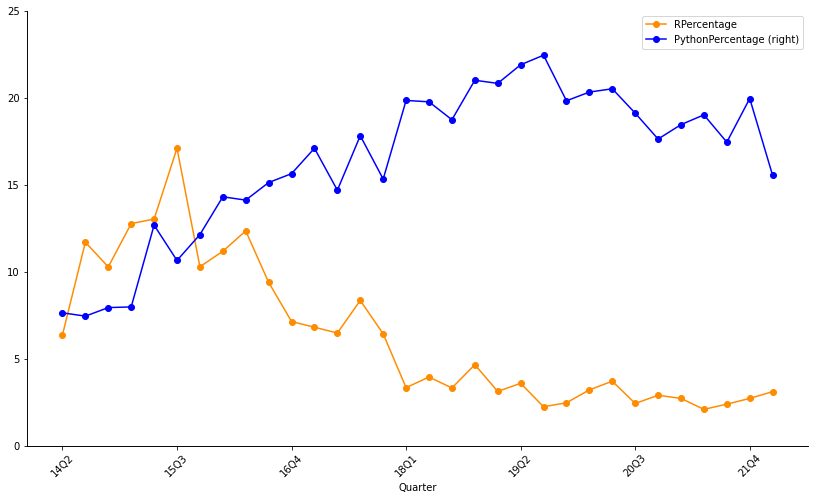

In [27]:
ax1 = r_df.plot(
    x='Quarter',
    y='RPercentage',
    kind='line',
    marker='o',
    color='darkorange',
    figsize=(14, 8)
    )

ax2 = r_df.plot(
    x='Quarter',
    y='PythonPercentage',
    kind='line',
    marker='o',
    color='b',
    ax=ax1,
    secondary_y=True,
    rot=45
    )

ax1.set_ylim(0, 25)
ax2.set_ylim(0, 25)

for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)


From 2014 Q2 to 2015 Q3, R was getting more and more popular and its popularity peaked in 2015 Q3, while Python was less popular than it. However, since then R's popularity was gradually declining, meanwhile Python's popularity was rising up. Since 2018, the percentage of R questions begins to flatten out and keeps around 3%, but Python is still higher than 15%.

We cannot conclude that R is potentially popular in the future according the line plots, further investigation and more factors are needed to understand R's popularity. For now, we will not recommend Datamagician to create contents using R, if they still want to, we suggest it should be some general knowledge in `machine-learning`.

<a id="act"></a>
## Act & Recommendations

* The most popular data science questions are related to Machine Learning, or more specically, Deep Learning. We suggest creating practical tutorials for tools like `tensorflow` and `scikit-learn` that focused on **Deep Learning** , using **Python**.

* **February** and **December**, **Saturday** and **Sunday** are months and days that have highest percentage of deeping learning questions, respectively. We suggest providing more coupons or discounts during that period to attract customers.

* We recommend Python rather than R given Python's popularity. If R tutorial is a must-have, we suggest focusing on general knowledge about **Machine Learning**.